# QDA (quadratic discriminant analysis)

## Difference to LDA
+   the assumtion that all classes have the same covariance matrix is relaxed $\rightarrow$ each class has its own

*   broadly speaking this effects the *disciminant function* that is now *quadratic* in $X$ and not *linear* 

    *   from this follows that the procedure around the covariance matrix is a bit different
    
⚠️**Warning**⚠️: Since the number of QDA parameters is *quadratic* in $p$, QDA should be used with care when $p$ is large

## Theory *gerneral discriminant problem*
*   Using Bayes theorem\
$Pr(G=k|X=x)=\frac{f_k(x)\pi_k} {\underset{l=1}{\overset{K}{\sum}}f_l(x)\pi_l}$
    *   $\pi_k$ is the prior probability for class $k$
    *   $f_k(x)$ is a probability density function that $x$ is in class $k$
* we model each class density as multivariate Gaussian\
\
$f_k(x)=\frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}$
    *   $\mu_k$ is the mean of observations in class $k$
    *   $p$ is the dimension on the data
    *   $\Sigma_k$ is the covariance matrix of class $k$ 

In [1]:
import math
import random
random.seed(9)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sample_size_Nk = 40

## Generate the sraining set
* maximum and minimum values and the sample size $N$ is derived from the set

In [3]:
k1 = pd.DataFrame([random.normalvariate(0,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k1['X2'] = [( x1 + random.normalvariate(2,0.7)) for x1 in k1["X1"]]
k1['Class'] = "K1"
k2 = pd.DataFrame([random.normalvariate(-1.5,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k2["X2"] = [ -x1 -random.normalvariate(1,1) for x1 in k2["X1"]]
k2['Class'] = "K2"
k3 = pd.DataFrame([random.normalvariate(2,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k3["X2"] = [ -x1 -random.normalvariate(2,1) for x1 in k2["X1"]]
k3['Class'] = "K3"
# k3 = pd.DataFrame([random.normalvariate(3,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
# k3["X2"] = [ -x1 +random.normalvariate(2,3) for x1 in k2["X1"]]
# k3['Class'] = "K3"
k4 = pd.DataFrame([random.normalvariate(0,1) for _ in range(sample_size_Nk)], columns=["X1"], dtype=float)
k4["X2"] = [ x1 + random.normalvariate(7,0.5) for x1 in k2["X1"]]
k4['Class'] = "K4"
X = pd.concat([k1, k2, k3, k4])
# set the dimensions new
dim_x_max, dim_y_max = X.max(axis=0)[0:2];
dim_x_min, dim_y_min = X.min(axis=0)[0:2];
dim_x_max += 0.5
dim_y_max += 0.5
dim_x_min -= 0.5
dim_y_min -= 0.5
print(f"{dim_x_min:.2f} < X1 < {dim_x_max:.2f}")
print(f"{dim_y_min:.2f} < X2 < {dim_y_max:.2f}")
sample_size_N = len(X.index)
print(f"sample size N = {sample_size_N}")
print(f"class count K = {len(X['Class'].unique()) }")
X

-4.02 < X1 < 4.29
-3.13 < X2 < 8.36
sample size N = 160
class count K = 4


,X1,X2,Class
0,-0.101266,2.584062,K1
1,0.242866,2.485527,K1
2,-1.268327,1.287919,K1
3,0.637025,2.064420,K1
4,0.458100,2.254820,K1
...,...,...,...
35,-2.007779,7.498208,K4
36,-0.104570,4.125084,K4
37,-1.054014,7.860899,K4
38,-0.622926,5.072713,K4


#### create dict and list for plotting
1.  A dictonary that translates class name to a integer for conturing
2.  A dictonary for the colour of the scatterplot circles
3.  A list such that the colour of the contour filling matches the scatter points colouring

In [4]:
class_dict = {}
color_dict = {}
color_list = []
t = plt.get_cmap("tab10")
for idx, k in enumerate(X['Class'].unique()):
    class_dict[k] = idx
    color_dict[k] = t(idx)
    color_list.append(t(idx))
print(class_dict)
print(color_dict)
print(color_list)

{'K1': 0, 'K2': 1, 'K3': 2, 'K4': 3}
{'K1': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'K2': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'K3': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'K4': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)}
[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)]


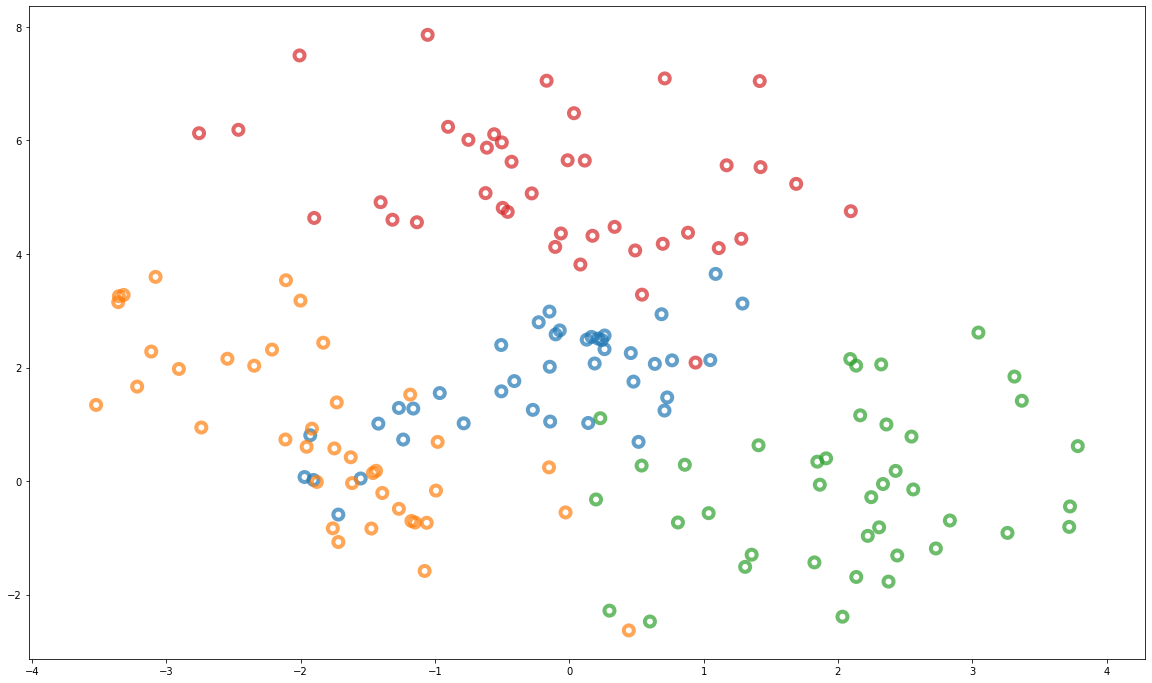

In [5]:
plt.figure(figsize=(20,12))
for c, rows in X.groupby('Class'):
    plt.scatter(rows["X1"], rows["X2"], facecolor='None', edgecolors=color_dict[c], alpha=0.7, s=100, linewidths=4)

plt.ylim([dim_y_min,dim_y_max])
plt.xlim([dim_x_min,dim_x_max])
plt.show()

## Estimate Paramters using training data

#### Prior probablity
*   prior probability of being class k\
\
$\hat\pi_k=\frac{N_k}{N}$
    +   $N$ is the total number of observations
    +   $N_k$ is the number of class-$k$ observations
#### Class mean 
*   the mean in a class $k$\
\
$\hat\mu_k=\underset{g_i = k}\sum\frac{x_i}{N_k}$
#### Class specific covariance matrices $\Sigma$
+   calc the variance matrix for each klass $k$\
$\hat\Sigma_k = \underset{g_i=k}{\sum}(x_i-\hat\mu_k)(x_i-\hat\mu_k)^T / (N_k-1)$
    +   basically the normal way to calculate the covariance matrix 
    +   at the end its adhusted by $N_k$ the number of observations in class $k$
        +   I think this has to do with degrees of freedom but not sure

In [6]:
sigmahat_dict = {} #np.zeros((len(X['Class'].unique()), len(X.columns)-1,len(X.columns)-1))
#print(sigmahat)
muhat = pd.DataFrame(columns=X['Class'].unique())
pi = pd.DataFrame( np.zeros((len(X['Class'].unique()),1)),columns=["count"], index=X['Class'].unique())
#muhat = df.Dataframe()
for c, rows in X.groupby('Class'):
    rows = rows.drop(columns="Class").T
    # print(c)
    muhat[c] = rows.mean(axis=1)
    #print(rows.shape[1])
    #print(rows)
    pi["count"][c] = rows.shape[1]
    sigmahat_dict[c] = rows.sub(rows.mean(axis=1), axis=0) @ rows.sub(rows.mean(axis=1), axis=0).T / (pi["count"][c] - 1)
    # print(rows.sub(rows.mean(axis=1), axis=0) @ rows.sub(rows.mean(axis=1), axis=0).T )# / (4))
    # print(np.cov(rows,ddof=1))
    # print(np.linalg.eig(np.cov(rows,ddof=0)))
# calc the proportion for pi
pi["proportion"] = pi["count"] / pi["count"].sum()
print("porportion pi")
display(pi)
print("means")
display(muhat)
for c, sigmahat in sigmahat_dict.items():
    print(f"covariance matrix for class: {c}")
    display(sigmahat)

porportion pi


,count,proportion
K1,40.0,0.25
K2,40.0,0.25
K3,40.0,0.25
K4,40.0,0.25


means


,K1,K2,K3,K4
X1,-0.210509,-1.852380,2.065111,-0.119850
X2,1.744025,0.849102,-0.131957,5.235708


covariance matrix for class: K1


,X1,X2
X1,0.801285,0.620532
X2,0.620532,0.923273


covariance matrix for class: K2


,X1,X2
X1,0.875154,-1.091180
X2,-1.091180,2.408177


covariance matrix for class: K3


,X1,X2
X1,0.937527,0.310510
X2,0.310510,1.716951


covariance matrix for class: K4


,X1,X2
X1,1.261068,-0.428902
X2,-0.428902,1.434065


## Using the linear discriminant functions

+   use the parameters estimated above

### ***Quadratic** discriminant function*
*   returns how likely the observation $x$ belongs to class $k$\
\
$\delta_k(x)=-\frac{1}{2}\log|\Sigma_k|-\frac{1}{2}(x-\hat\mu_k)^T\Sigma_k^{-1}(x-\hat\mu_k)+\log(\pi_k)$

### Classification using $\delta_k(x$)
*   using the *linear discriminant function* to decided which class fits best\
\
$G(x)= \underset{k}\argmax\text{ }\delta_k(x)$
 


In [8]:
# book 4.12
delta_kx = lambda x, k: -(1/2) * math.log(np.linalg.det(sigmahat_dict[k])) - (1/2) * ((x - muhat[k]).T @  np.linalg.inv(sigmahat_dict[k]) @ (x - muhat[k])) + math.log(pi["proportion"][k])

def argmax_k(x):
    deltas = []
    for c in X['Class'].unique():
        deltas.append((delta_kx(x, c), c))
    _, c = max(deltas)
    return class_dict[c]

### Evaluate the classificator in a grid for plotting

In [9]:
xx = np.linspace(dim_x_min, dim_x_max, 300)
yy = np.linspace(dim_y_min, dim_y_max, 300)
list = []
for yi in yy:
    col = []
    for xi in xx:
        # print(xi, yi)
        col.append(argmax_k(np.array([xi,yi])))
    list.append(col)
zz = np.array(list)
# print(zz)

### Plot
1.  Plot the conture of $G(x)$
2.  Plot the training data

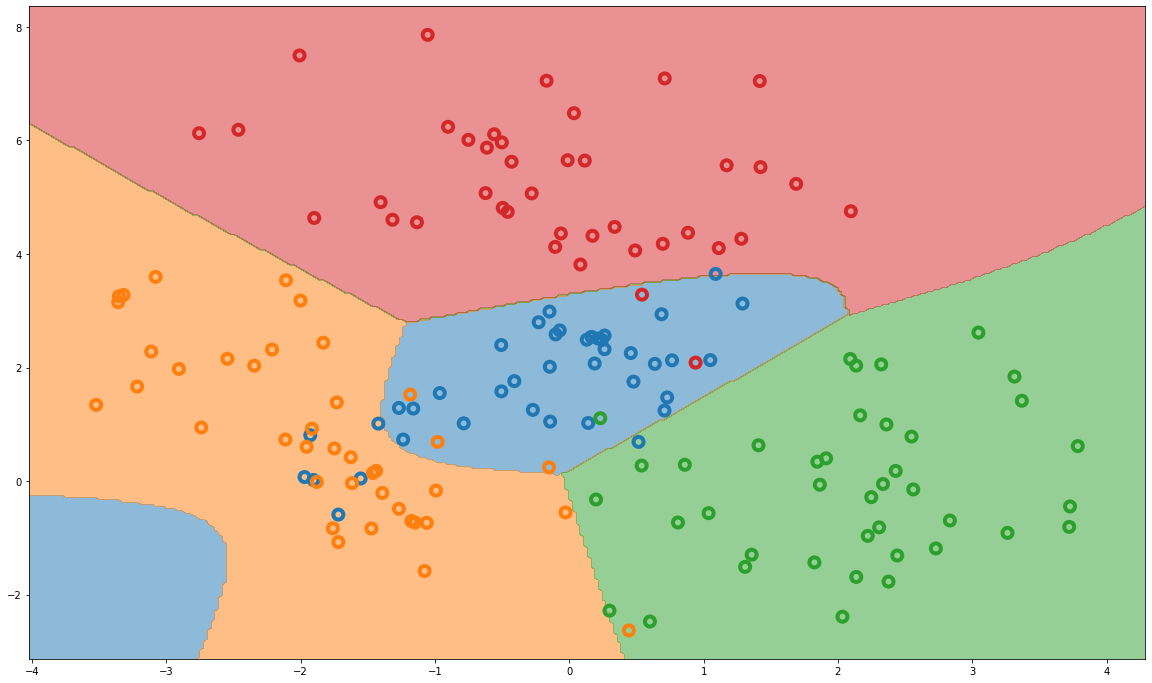

In [10]:

plt.figure(figsize=(20,12))
# plt.rcParams["figure.dpi"] = (1000)
h = plt.contourf(xx, yy, zz, levels=(len(class_dict)-1), alpha = 0.5, colors=color_list)
for c, rows in X.groupby('Class'):
    plt.scatter(rows["X1"], rows["X2"], facecolor='None', edgecolors=color_dict[c], alpha=1, s=100, linewidths=4)
plt.ylim([dim_y_min,dim_y_max])
plt.xlim([dim_x_min,dim_x_max])
plt.show()